# Bangla MultiClass Text Classification

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress INFO, WARNING, and ERROR logs from TensorFlow


In [2]:
# setting up the libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_fscore_support
)
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# TensorFlow and Transformers
import tensorflow as tf
from transformers import (
    AutoTokenizer,
    TFAutoModelForSequenceClassification,
    DataCollatorWithPadding # Can be useful for tf.data.Dataset
)

# LIME for model's interpretability
import lime
import lime.lime_text


E0000 00:00:1748668772.999884      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748668773.117393      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Important Setups

In [3]:

# To use Bangla font in WordCloud

BANGLA_FONT_PATH = '/kaggle/input/banglafront/NotoSansBengali-Regular.ttf'

In [4]:
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 1. Dataset Loading and Exploratory Data Analysis (EDA)

In [5]:
# Load the dataset
df = pd.read_csv("/kaggle/input/bangladata/Bangla_news.csv")

In [6]:
# displaying how the actual dataset looks like.
df.head()

,title,published_date,reporter,category,url,content
0,"সিন নদীতে ব্যাপক দূষণ, স্থগিত করা হলো ট্রায়াথ...","30th July, 2024 5:59 pm",আরআইএম,sports,https://jamuna.tv/news/552127,ছবি: সংগৃহীত সিন নদীতে অলিম্পিকের উদ্বোধনী অনু...
1,এসিসির নতুন সভাপতি হচ্ছেন মহসিন নাকভি!,"30th July, 2024 5:25 pm",NaN,sports,https://jamuna.tv/news/552123,২০২৫ সালের জানুয়ারিতে এশিয়ান ক্রিকেট কাউন্স...
2,২০৩০ ও ২০৩৪ বিশ্বকাপের হোস্ট জানা যাবে দুইদিন পর!,"30th July, 2024 1:22 pm",আরআইএম,sports,https://jamuna.tv/news/552066,ফিফা বিশ্বকাপ ২০৩০ ও ৩৪ সালের স্বাগতিক হবার ল...
3,প্যারিস অলিম্পিক: কোয়ার্টার ফাইনালে ওঠার লক্ষ্...,"30th July, 2024 11:54 am",এনকে,sports,https://jamuna.tv/news/552046,প্যারিস অলিম্পিকে কোয়ার্টার ফাইনাল রেসে টিকে ...
4,আজ টিভিতে যা দেখবেন (৩০ জুলাই ২০২৪),"30th July, 2024 7:01 am",এনকে,sports,https://jamuna.tv/news/552016,আজ ভারত–শ্রীলঙ্কার তৃতীয় টি–টোয়েন্টি অলিম্পিকে...


In [7]:
df.shape

(11904, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11904 entries, 0 to 11903
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           11904 non-null  object
 1   published_date  11904 non-null  object
 2   reporter        10914 non-null  object
 3   category        11904 non-null  object
 4   url             11904 non-null  object
 5   content         11904 non-null  object
dtypes: object(6)
memory usage: 558.1+ KB


In [9]:
df.isnull().sum()

title               0
published_date      0
reporter          990
category            0
url                 0
content             0
dtype: int64

Categories in 'category':
 category
sports           2976
international    2976
entertainment    2976
national         2976
Name: count, dtype: int64


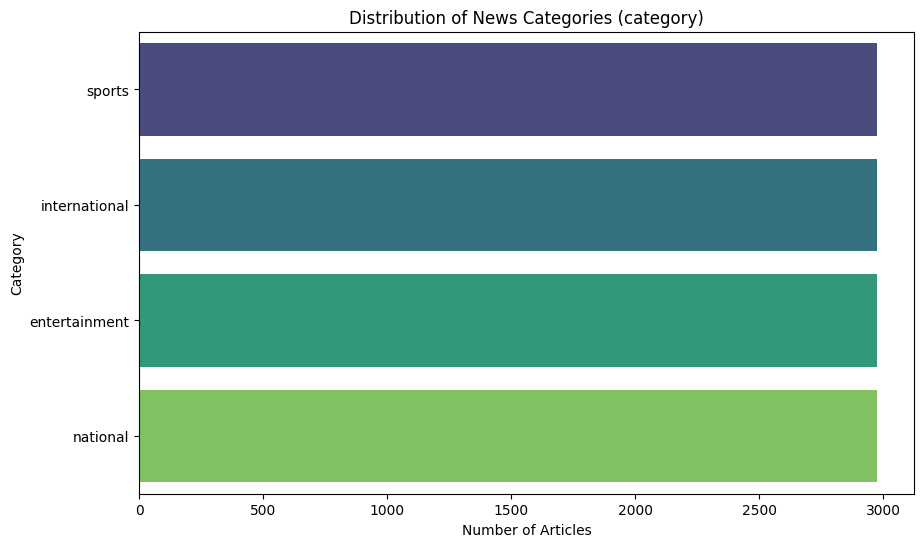

In [10]:
# Target Variable Distribution

target_column = 'category'
print(f"Categories in '{target_column}':\n", df[target_column].value_counts())
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y=target_column, order=df[target_column].value_counts().index, palette="viridis")
plt.title(f'Distribution of News Categories ({target_column})')
plt.xlabel('Number of Articles')
plt.ylabel('Category')
plt.show()


In [11]:
# Missing Value Analysis
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Count': missing_values, 'Percentage': missing_percent})
missing_df = missing_df[missing_df['Count'] > 0].sort_values(by='Percentage', ascending=False)
print("Missing Values:\n", missing_df)



Missing Values:
           Count  Percentage
reporter    990    8.316532


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


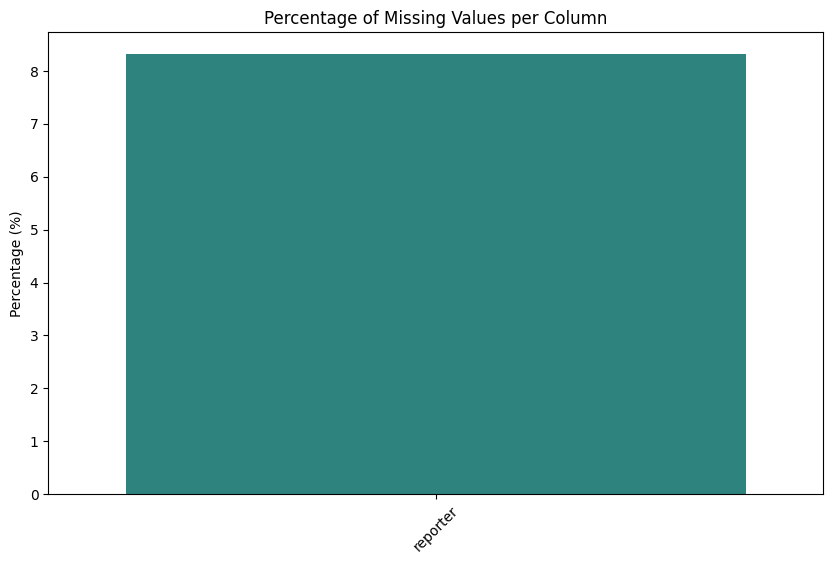

In [12]:
if not missing_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_df.index, y='Percentage', data=missing_df, palette="viridis")
    plt.title('Percentage of Missing Values per Column')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No missing values found in the dataset.")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


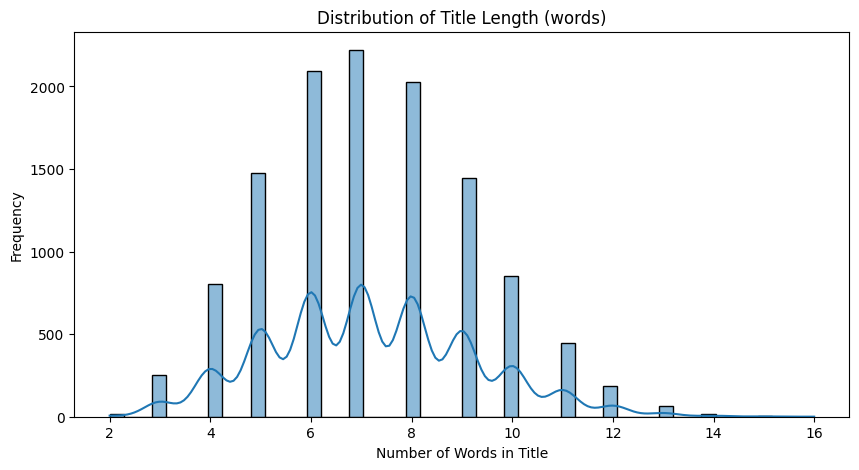

In [13]:
df['title_len'] = df['title'].astype(str).apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(df['title_len'], kde=True, bins=50)
plt.title('Distribution of Title Length (words)')
plt.xlabel('Number of Words in Title')
plt.ylabel('Frequency')
plt.show()



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


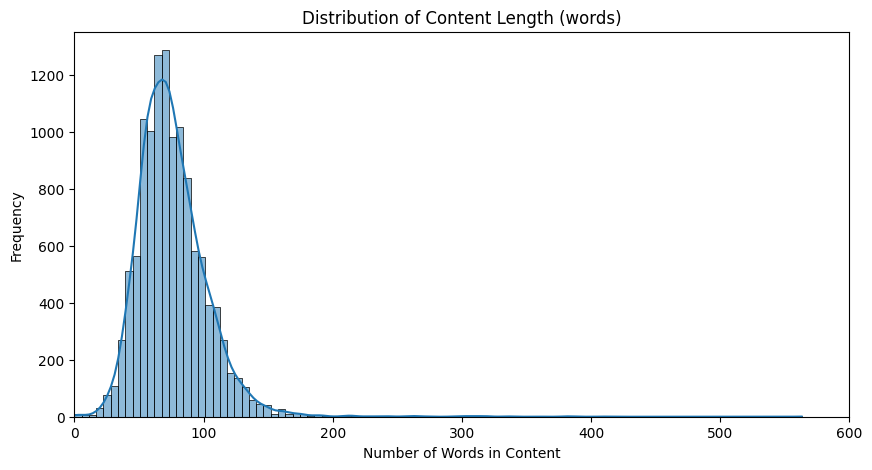

In [14]:
# Calculate word counts
df['content_len'] = df['content'].astype(str).apply(lambda x: len(x.split()))


# Plot Content Length Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['content_len'], kde=True, bins=100)
plt.title('Distribution of Content Length (words)')
plt.xlabel('Number of Words in Content')
plt.ylabel('Frequency')
plt.xlim(0, 600) 
plt.show()



In [15]:

print("Title length desc:\n", df['title_len'].describe())
print("\nContent length desc:\n", df['content_len'].describe())


Title length desc:
 count    11904.000000
mean         7.184224
std          2.049890
min          2.000000
25%          6.000000
50%          7.000000
75%          9.000000
max         16.000000
Name: title_len, dtype: float64

Content length desc:
 count    11904.000000
mean        76.011173
std         27.812646
min          0.000000
25%         58.000000
50%         72.000000
75%         90.000000
max        563.000000
Name: content_len, dtype: float64


In [16]:
# Duplicate Check
print(f"Number of rows before dropping duplicates: {df.shape[0]}")
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
print(f"Shape after dropping exact duplicates (all columns): {df.shape}")

print(f"Number of duplicate titles: {df.duplicated(subset=['title']).sum()}")
print(f"Number of duplicate contents: {df.duplicated(subset=['content']).sum()}")


Number of rows before dropping duplicates: 11904
Shape after dropping exact duplicates (all columns): (11904, 8)
Number of duplicate titles: 70
Number of duplicate contents: 59


<Figure size 1000x600 with 0 Axes>

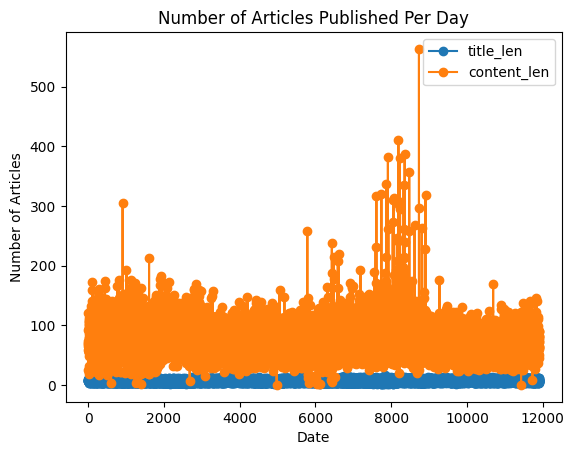

In [17]:
# Plot the number of articles published per day
plt.figure(figsize=(10, 6))
df.plot(kind='line', marker='o')
plt.title('Number of Articles Published Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()


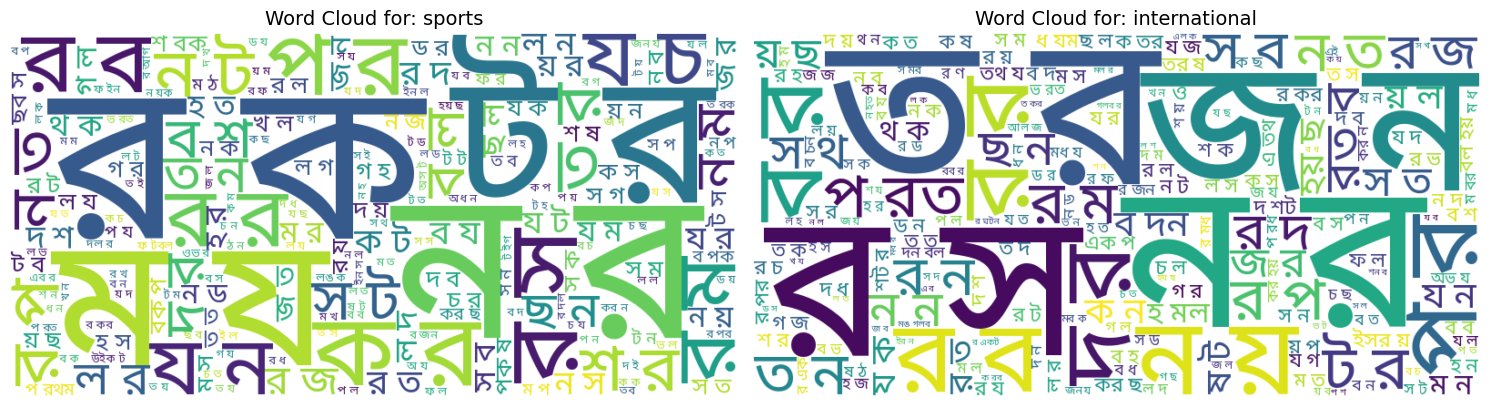

In [18]:
# Word Clouds (Bang font)
def clean_text_for_wordcloud(text):
    text = str(text)
    # Keep Bangla characters, numbers (like dates), and spaces. Remove other punctuation.
    text = re.sub(r'[^\u0980-\u09FF\s\d]', '', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

if BANGLA_FONT_PATH:
    categories_to_plot = df[target_column].value_counts().index[:2] # Top 2 categories
    plt.figure(figsize=(15, 7))
    for i, category_val in enumerate(categories_to_plot): 
        plt.subplot(1, len(categories_to_plot), i + 1)
        text_corpus = " ".join(df[df[target_column] == category_val]['content'].fillna('').apply(clean_text_for_wordcloud))
        if text_corpus:
            wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=BANGLA_FONT_PATH).generate(text_corpus)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Word Cloud for: {category_val}', fontdict={'fontsize': 14})
        else:
            plt.text(0.5, 0.5, 'No text for word cloud', ha='center', va='center'); plt.axis('off'); plt.title(f'Word Cloud for: {category_val} (No Text)')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping WordCloud generation as Bangla font path is not configured.")


# 1.1. Profiling

In [19]:
#Profiling 

from ydata_profiling import ProfileReport # this will help us to generate report on our dataset.
#now we have to create profile report

report = ProfileReport(df, title = 'Report of our Dataset',explorative =True)
report.to_file('/kaggle/working/Dataset_Report.html')


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 2. Data Preprocessing and Feature Engineering


In [20]:
# Drop unnecessary columns 
# Also dropping EDA-specific length columns
df = df.drop(columns=["reporter", "url", "published_date", "title_len_eda", "content_len_eda"], errors='ignore')

# Combine title and content into 'raw_text' for BERT, and 'text' for others
df["raw_text"] = df["title"] + " [SEP] " + df["content"] # For BERT, keep punctuation etc.
df["text_for_others"] = df["title"] + " " + df["content"] # For other models that will be cleaned

# Drop original title and content
df = df.drop(columns=["title", "content"])

# Drop duplicates and nulls if any (based on combined text and category)
df.drop_duplicates(subset=['raw_text', 'category'], inplace=True)
df.dropna(subset=['raw_text', 'category'], inplace=True)
df.reset_index(drop=True, inplace=True)

print("Shape after cleaning and feature combination:", df.shape)
df.head(2)



Shape after cleaning and feature combination: (11904, 5)


,category,title_len,content_len,raw_text,text_for_others
0,sports,9,92,"সিন নদীতে ব্যাপক দূষণ, স্থগিত করা হলো ট্রায়াথ...","সিন নদীতে ব্যাপক দূষণ, স্থগিত করা হলো ট্রায়াথ..."
1,sports,6,73,এসিসির নতুন সভাপতি হচ্ছেন মহসিন নাকভি! [SEP] ...,এসিসির নতুন সভাপতি হচ্ছেন মহসিন নাকভি! ২০২৫ স...


In [21]:
# Text Cleaning function for non-BERT models
def clean_text_non_bert(text):
    text = str(text)
    text = re.sub(r"[^\u0980-\u09FF\s]", " ", text) 
    text = re.sub(r"\s+", " ", text) 
    return text.strip()

df["clean_text"] = df["text_for_others"].apply(clean_text_non_bert)
df.head(2)


,category,title_len,content_len,raw_text,text_for_others,clean_text
0,sports,9,92,"সিন নদীতে ব্যাপক দূষণ, স্থগিত করা হলো ট্রায়াথ...","সিন নদীতে ব্যাপক দূষণ, স্থগিত করা হলো ট্রায়াথ...",সিন নদীতে ব্যাপক দূষণ স্থগিত করা হলো ট্রায়াথল...
1,sports,6,73,এসিসির নতুন সভাপতি হচ্ছেন মহসিন নাকভি! [SEP] ...,এসিসির নতুন সভাপতি হচ্ছেন মহসিন নাকভি! ২০২৫ স...,এসিসির নতুন সভাপতি হচ্ছেন মহসিন নাকভি ২০২৫ সাল...


In [22]:
#  3.2 Label Encoding

le = LabelEncoder()
df["label"] = le.fit_transform(df["category"])
class_names = list(le.classes_)
num_classes = len(class_names)
label_mapping = {index: label_val for index, label_val in enumerate(class_names)}

print(f"Number of unique classes: {num_classes}")
print("Class names:", class_names)
print("Label mapping:", label_mapping)


Number of unique classes: 4
Class names: ['entertainment', 'international', 'national', 'sports']
Label mapping: {0: 'entertainment', 1: 'international', 2: 'national', 3: 'sports'}


# 3. Dataset Splitting - Train, Test, Validation

In [23]:
# Train-Validation-Test Split (70-15-15)
# X_raw for BERT, X_clean for other models


X_raw = df["raw_text"]
X_clean = df["clean_text"]
y = df["label"]

# Split raw text for BERT
X_train_raw, X_temp_raw, y_train_bert, y_temp_bert = train_test_split(
    X_raw, y, test_size=0.30, stratify=y, random_state=SEED
)
X_val_raw, X_test_raw, y_val_bert, y_test_bert = train_test_split(
    X_temp_raw, y_temp_bert, test_size=0.50, stratify=y_temp_bert, random_state=SEED
)

# Split clean text for other models 
y_train = y_train_bert
y_val = y_val_bert
y_test = y_test_bert

X_train_clean = X_clean[X_train_raw.index]
X_val_clean = X_clean[X_val_raw.index]
X_test_clean = X_clean[X_test_raw.index]


print("Data Split Sizes:")
print(f"Train:      X_raw={len(X_train_raw)}, X_clean={len(X_train_clean)}, y={len(y_train)}")
print(f"Validation: X_raw={len(X_val_raw)},   X_clean={len(X_val_clean)},   y={len(y_val)}")
print(f"Test:       X_raw={len(X_test_raw)},    X_clean={len(X_test_clean)},    y={len(y_test)}")


Data Split Sizes:
Train:      X_raw=8332, X_clean=8332, y=8332
Validation: X_raw=1786,   X_clean=1786,   y=1786
Test:       X_raw=1786,    X_clean=1786,    y=1786


In [24]:
# Convert y to numpy arrays for Keras/TF
from tensorflow.keras.utils import to_categorical

y_train_np = np.array(y_train)
y_val_np = np.array(y_val)
y_test_np = np.array(y_test)

y_train_cat = to_categorical(y_train_np, num_classes=num_classes)
y_val_cat = to_categorical(y_val_np, num_classes=num_classes)
y_test_cat = to_categorical(y_test_np, num_classes=num_classes)


# 4. Model Creation

# Model Implementation : 6 Models
## We are going to implement 6 models on this project to classify Bangla Text.
1. TF-IDF with Linier Regression
2. TF-IDF with Random Forest
3. LSTM with Embedding
4. CNN with Embedding
5. Transformers : BERT base Multilangual
6. Transformers : Bangla BERT 

# 4.1 Model's Performance Collector

In [25]:
# Store metrics for final comparison
model_performance = {}

# Consistent evaluation function
def evaluate_model_performance(model_name, y_true, y_pred, y_proba=None):
    accuracy = accuracy_score(y_true, y_pred)
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
    report_str = classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0)
    
    print(f"\n--- {model_name} Evaluation on TEST SET ---")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nTest Classification Report:\n", report_str)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC AUC
    roc_auc_macro = None
    if y_proba is not None and num_classes > 1:
        y_true_bin = label_binarize(y_true, classes=range(num_classes))
        
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
            roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_proba[:, i])
        
        # Macro-average ROC
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(num_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= num_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = roc_auc_score(y_true_bin, y_proba, average="macro", multi_class="ovr")
        roc_auc_macro = roc_auc["macro"]

        plt.figure(figsize=(10, 7))
        plt.plot(fpr["macro"], tpr["macro"],
                 label=f'Macro-average ROC (area = {roc_auc["macro"]:.4f})',
                 color='navy', linestyle=':', linewidth=4)
        colors = sns.color_palette("husl", num_classes)
        for i, color in zip(range(num_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'ROC of class {label_mapping[i]} (area = {roc_auc[i]:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves - {model_name}')
        plt.legend(loc="lower right"); plt.show()
        
        print(f"Macro Average AUC-ROC: {roc_auc_macro:.4f}")

    model_performance[model_name] = {
        'Accuracy': accuracy,
        'Macro F1': report_dict['macro avg']['f1-score'],
        'Weighted F1': report_dict['weighted avg']['f1-score'],
        'Macro AUC': roc_auc_macro if roc_auc_macro is not None else 'N/A'
    }


# 4.2. Model 1: TF-IDF + Logistic Regression (Baseline) 
## [Model 1: Creation - Training - Evaluation]



--- Logistic Regression Evaluation on TEST SET ---
Test Accuracy: 0.9177

Test Classification Report:
                precision    recall  f1-score   support

entertainment     0.9000    0.9262    0.9129       447
international     0.9220    0.8744    0.8976       446
     national     0.8929    0.9329    0.9125       447
       sports     0.9587    0.9372    0.9478       446

     accuracy                         0.9177      1786
    macro avg     0.9184    0.9177    0.9177      1786
 weighted avg     0.9184    0.9177    0.9177      1786



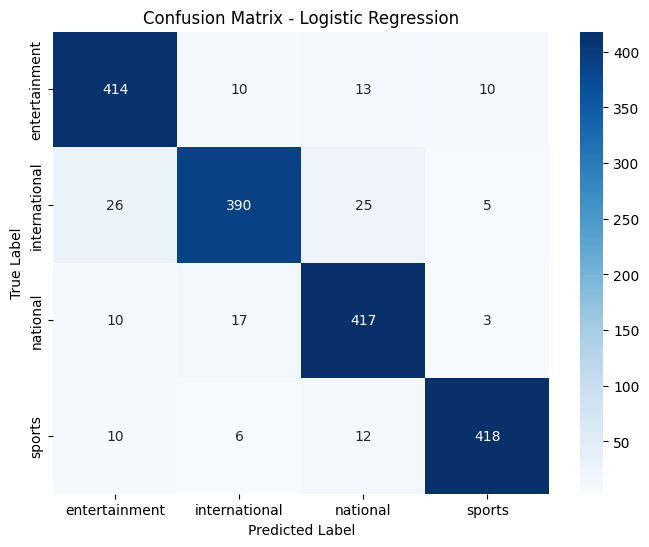

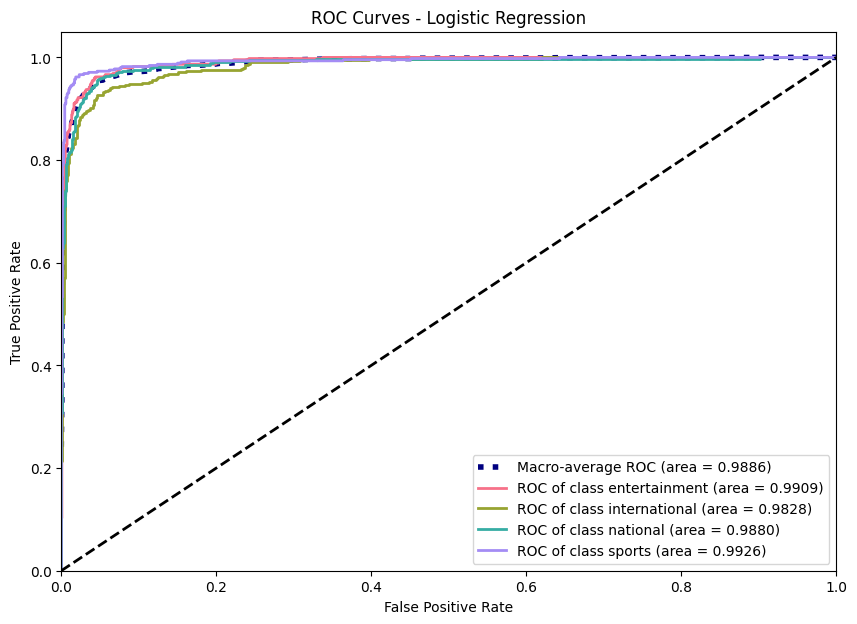

Macro Average AUC-ROC: 0.9886


In [26]:
tfidf_lr = TfidfVectorizer(max_features=5000, ngram_range=(1,2)) # Using max_features from user
X_train_tfidf_lr = tfidf_lr.fit_transform(X_train_clean) # Use X_train_clean
X_test_tfidf_lr = tfidf_lr.transform(X_test_clean)     # Use X_test_clean

lr_model = LogisticRegression(max_iter=200, random_state=SEED, solver='liblinear') 
lr_model.fit(X_train_tfidf_lr, y_train)

y_pred_lr = lr_model.predict(X_test_tfidf_lr)
y_proba_lr = lr_model.predict_proba(X_test_tfidf_lr)
evaluate_model_performance("Logistic Regression", y_test, y_pred_lr, y_proba_lr)



# 4.3. Model 2: TF-IDF + Random Forest 
## [Model 2: Creation - Training - Evaluation]


--- Random Forest Evaluation on TEST SET ---
Test Accuracy: 0.9037

Test Classification Report:
                precision    recall  f1-score   support

entertainment     0.9055    0.8792    0.8922       447
international     0.9161    0.8565    0.8853       446
     national     0.8698    0.9418    0.9044       447
       sports     0.9268    0.9372    0.9320       446

     accuracy                         0.9037      1786
    macro avg     0.9046    0.9037    0.9035      1786
 weighted avg     0.9045    0.9037    0.9035      1786



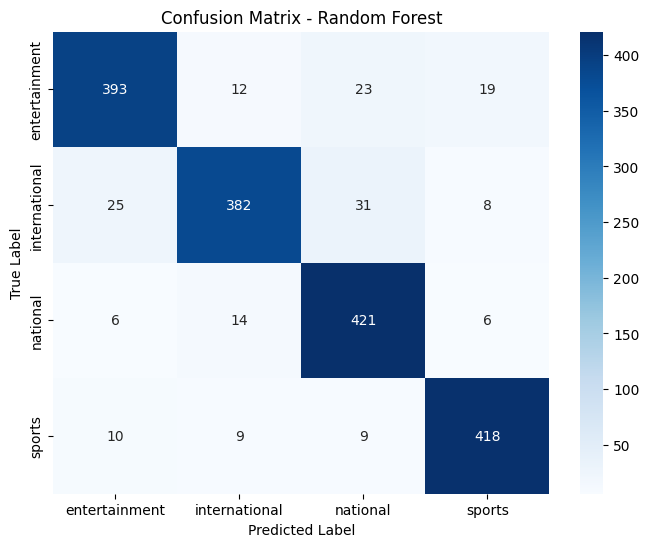

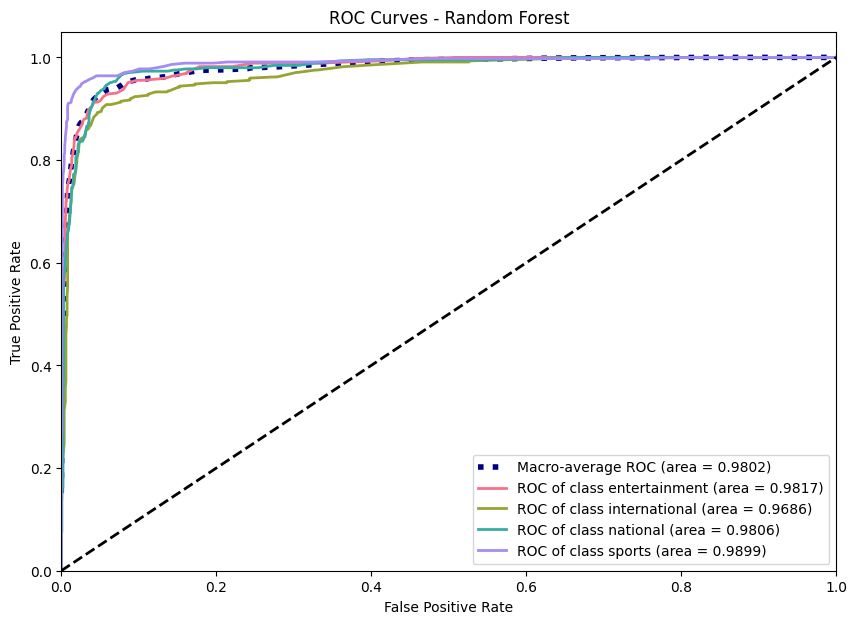

Macro Average AUC-ROC: 0.9802


In [27]:
# TF-IDF + Random Forest
from sklearn.ensemble import RandomForestClassifier


# TF-IDF features are already created (X_train_tfidf_lr, X_test_tfidf_lr can be reused)
tfidf_rf = TfidfVectorizer(max_features=5000, ngram_range=(1,2)) 
X_train_tfidf_rf = tfidf_rf.fit_transform(X_train_clean)
X_test_tfidf_rf = tfidf_rf.transform(X_test_clean)

rf_model = RandomForestClassifier(n_estimators=100, random_state=SEED) 
rf_model.fit(X_train_tfidf_rf, y_train)

y_pred_rf = rf_model.predict(X_test_tfidf_rf)
y_proba_rf = rf_model.predict_proba(X_test_tfidf_rf)
evaluate_model_performance("Random Forest", y_test, y_pred_rf, y_proba_rf)


# 4.4. Model 3: Keras LSTM with Embedding
## [Model 3: Creation - Training - Evaluation]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1748668855.688209      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748668855.688987      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 588ms/step - accuracy: 0.4356 - loss: 1.1736 - val_accuracy: 0.8679 - val_loss: 0.3802
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 76s 582ms/step - accuracy: 0.8868 - loss: 0.3556 - val_accuracy: 0.9429 - val_loss: 0.1850
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 76s 580ms/step - accuracy: 0.9610 - loss: 0.1556 - val_accuracy: 0.9462 - val_loss: 0.1886
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 76s 582ms/step - accuracy: 0.9738 - loss: 0.1060 - val_accuracy: 0.9518 - val_loss: 0.1928
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step

--- LSTM Evaluation on TEST SET ---
Test Accuracy: 0.9446

Test Classification Report:
                precision    recall  f1-score   support

entertainment     0.9629    0.9284    0.9453       447
international     0.9167    0.9372    0.9268       446
     national     0.9194    0.9441    0.9316       447
       sports     0.9818    0.9686    0.9752       446

     accuracy                         0.9446      1786
    macro avg 

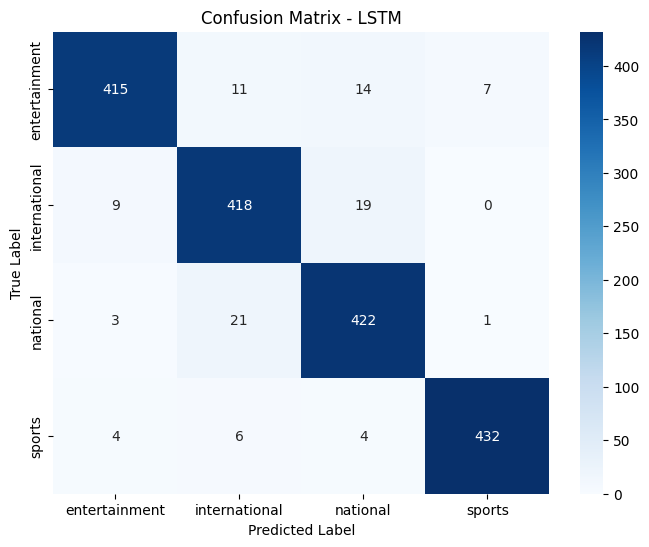

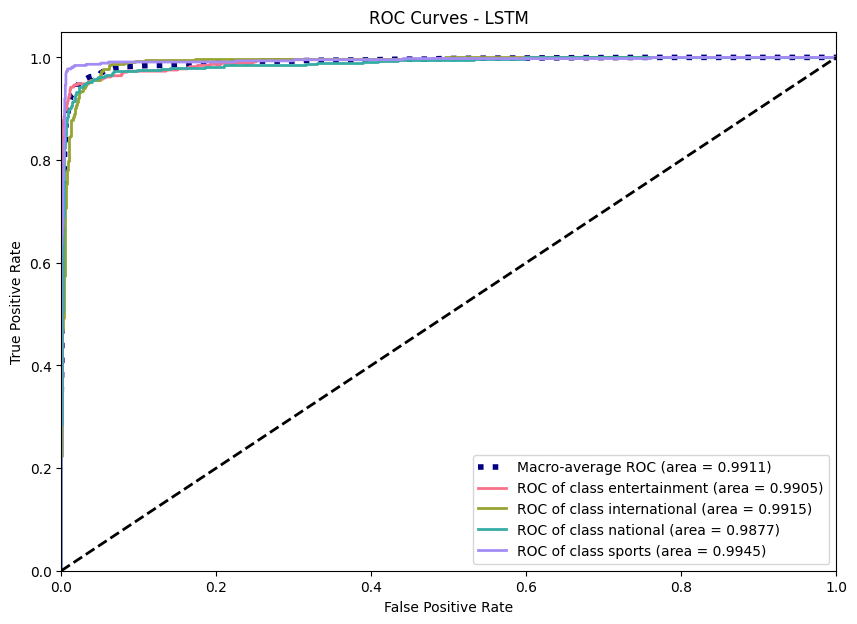

Macro Average AUC-ROC: 0.9911


In [28]:
# Keras LSTM with Embedding

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# Uses `X_train_clean`, `X_val_clean`, `X_test_clean`.

# Keras Tokenization for LSTM/CNN
MAX_WORDS_RNN = 10000
MAX_LEN_RNN = 200     

keras_tokenizer = Tokenizer(num_words=MAX_WORDS_RNN, oov_token="<OOV>")
keras_tokenizer.fit_on_texts(X_train_clean) 

X_train_seq = pad_sequences(keras_tokenizer.texts_to_sequences(X_train_clean), maxlen=MAX_LEN_RNN)
X_val_seq = pad_sequences(keras_tokenizer.texts_to_sequences(X_val_clean), maxlen=MAX_LEN_RNN)
X_test_seq = pad_sequences(keras_tokenizer.texts_to_sequences(X_test_clean), maxlen=MAX_LEN_RNN)

# LSTM model 
lstm_model = Sequential([
    Embedding(input_dim=MAX_WORDS_RNN, output_dim=128, input_length=MAX_LEN_RNN),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

early_stopping_rnn = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lstm_model.fit(X_train_seq, y_train_cat, epochs=10, batch_size=64, 
               validation_data=(X_val_seq, y_val_cat), callbacks=[early_stopping_rnn])

y_proba_lstm = lstm_model.predict(X_test_seq)
y_pred_lstm = np.argmax(y_proba_lstm, axis=1)
evaluate_model_performance("LSTM", y_test_np, y_pred_lstm, y_proba_lstm) # y_test_np for true labels



# 4.5. Model 4: Keras CNN with Embedding
## [Model 4: Creation - Training - Evaluation]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1748669182.106230      71 service.cc:148] XLA service 0x19cef630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748669182.107581      71 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748669182.107600      71 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748669182.452675      71 cuda_dnn.cc:529] Loaded cuDNN version 90300


 40/131 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3194 - loss: 1.3699

I0000 00:00:1748669187.924196      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.5084 - loss: 1.1552 - val_accuracy: 0.9418 - val_loss: 0.1913
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9561 - loss: 0.1646 - val_accuracy: 0.9653 - val_loss: 0.1312
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9863 - loss: 0.0547 - val_accuracy: 0.9642 - val_loss: 0.1474
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9920 - loss: 0.0325 - val_accuracy: 0.9647 - val_loss: 0.1428
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

--- CNN Evaluation on TEST SET ---
Test Accuracy: 0.9563

Test Classification Report:
                precision    recall  f1-score   support

entertainment     0.9589    0.9396    0.9492       447
international     0.9392    0.9350    0.9371       446
     national     0.9432    0.9664    0.9547       447
       sports     0.9843    0.9843    0.9843       446

     accuracy                         0.9563      1786
    macro avg     0.9564    0.9563    

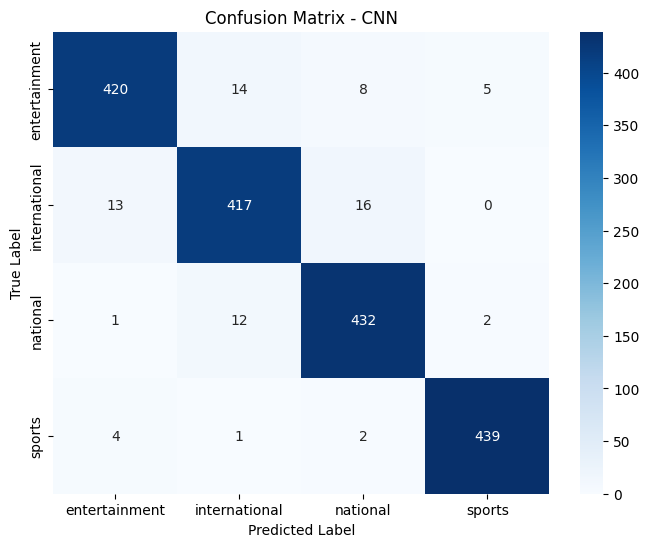

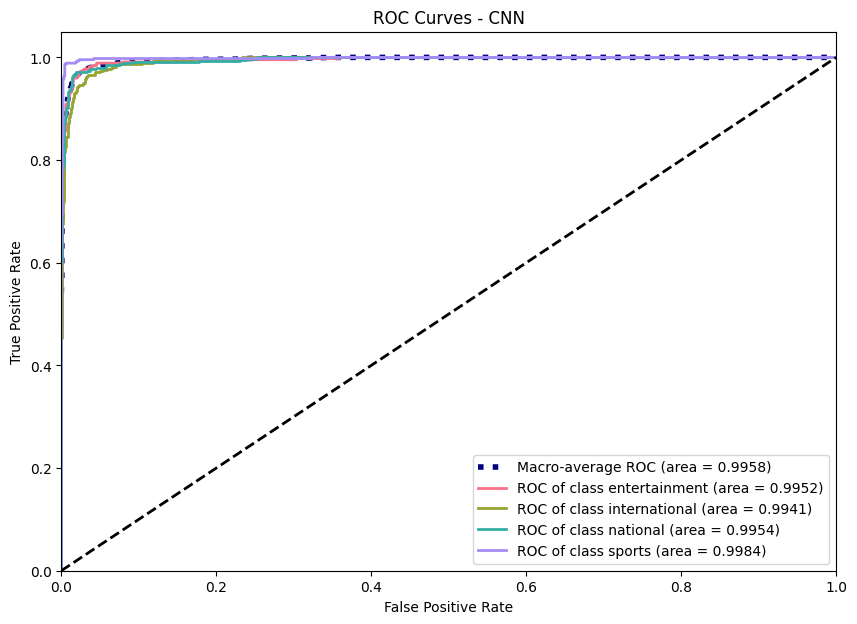

Macro Average AUC-ROC: 0.9958


In [29]:
# Keras CNN with Embedding
# Uses `X_train_clean`, `X_val_clean`, `X_test_clean` (and same Keras tokenizer/sequences as LSTM).

from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

cnn_model = Sequential([
    Embedding(input_dim=MAX_WORDS_RNN, output_dim=128, input_length=MAX_LEN_RNN),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

cnn_model.fit(X_train_seq, y_train_cat, epochs=10, batch_size=64, 
              validation_data=(X_val_seq, y_val_cat), callbacks=[early_stopping_rnn]) 

y_proba_cnn = cnn_model.predict(X_test_seq)
y_pred_cnn = np.argmax(y_proba_cnn, axis=1)
evaluate_model_performance("CNN", y_test_np, y_pred_cnn, y_proba_cnn)


# 4.6 Model 5: BERT (bert-base-multilingual-cased) with TensorFlow/Keras
## [Model 5: Creation - Hyper Parameter Tuning - Training - Evaluation]


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
Total params: 177856516 (678.47 MB)
Trainable params: 177856516 (678.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
521/521 [==============================] - 324s 519ms/step - loss: 0.4683 - accuracy: 0.8305 - val_loss: 0.1979 - val_accuracy: 0.9390
Epoch 2/5
521/521 [==============================] - 265s 509ms/step - loss: 0.1715 - accuracy: 0.9471 -

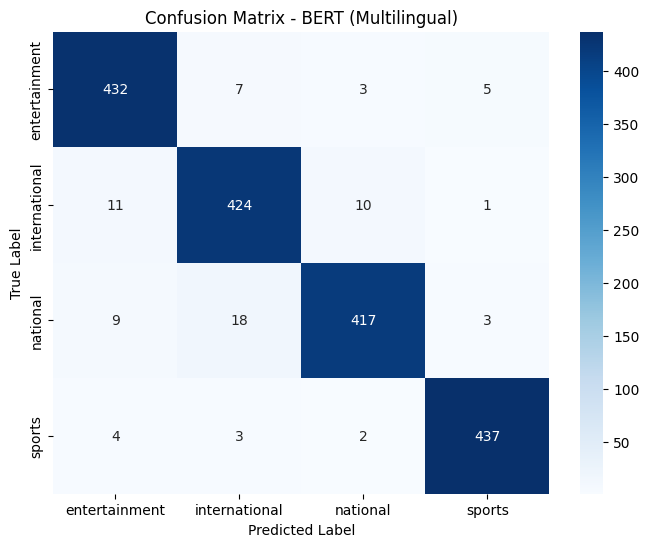

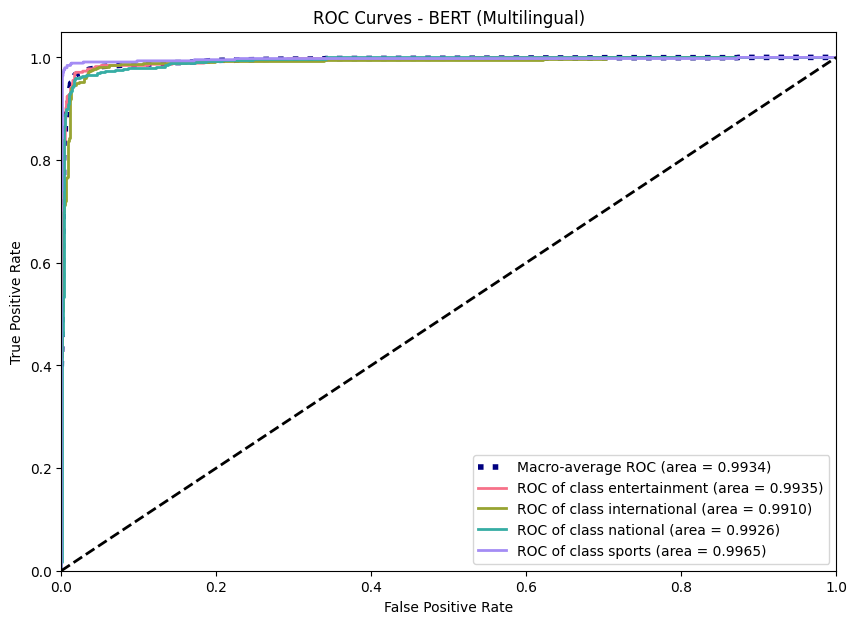

Macro Average AUC-ROC: 0.9934


In [30]:
# BERT (bert-base-multilingual-cased) with TensorFlow/Keras

# Uses `X_train_raw`, `X_val_raw`, `X_test_raw`.
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, create_optimizer

BERT_MODEL_MULTI = "bert-base-multilingual-cased" 
MAX_LEN_BERT = 128 
BATCH_SIZE_BERT = 16 

tokenizer_multi_bert = AutoTokenizer.from_pretrained(BERT_MODEL_MULTI)

X_train_enc_multi = tokenizer_multi_bert(list(X_train_raw), truncation=True, padding='max_length', max_length=MAX_LEN_BERT, return_tensors='tf')
X_val_enc_multi = tokenizer_multi_bert(list(X_val_raw), truncation=True, padding='max_length', max_length=MAX_LEN_BERT, return_tensors='tf')
X_test_enc_multi = tokenizer_multi_bert(list(X_test_raw), truncation=True, padding='max_length', max_length=MAX_LEN_BERT, return_tensors='tf')

# Prepare TF Datasets for BERT model.fit
train_bert_multi_inputs = {'input_ids': X_train_enc_multi['input_ids'], 'attention_mask': X_train_enc_multi['attention_mask']}
val_bert_multi_inputs = {'input_ids': X_val_enc_multi['input_ids'], 'attention_mask': X_val_enc_multi['attention_mask']}
test_bert_multi_inputs = {'input_ids': X_test_enc_multi['input_ids'], 'attention_mask': X_test_enc_multi['attention_mask']}

bert_model_multi = TFAutoModelForSequenceClassification.from_pretrained(BERT_MODEL_MULTI, num_labels=num_classes)

EPOCHS_BERT = 5
LEARNING_RATE_BERT = 3e-5 

num_train_steps_multi = int(len(X_train_raw) / BATCH_SIZE_BERT * EPOCHS_BERT)
num_warmup_steps_multi = int(0.1 * num_train_steps_multi)

optimizer_bert_multi, _ = create_optimizer(
    init_lr=LEARNING_RATE_BERT,
    num_warmup_steps=num_warmup_steps_multi,
    num_train_steps=num_train_steps_multi
)
bert_model_multi.compile(optimizer=optimizer_bert_multi, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
bert_model_multi.summary()


bert_model_multi.fit(
    train_bert_multi_inputs, y_train_np,
    validation_data=(val_bert_multi_inputs, y_val_np),
    epochs=EPOCHS_BERT, batch_size=BATCH_SIZE_BERT
)

y_logits_bert_multi = bert_model_multi.predict(test_bert_multi_inputs)[0]
y_proba_bert_multi = tf.nn.softmax(y_logits_bert_multi, axis=1).numpy()
y_pred_bert_multi = np.argmax(y_proba_bert_multi, axis=1)
evaluate_model_performance("BERT (Multilingual)", y_test_np, y_pred_bert_multi, y_proba_bert_multi)


# 4.7. Model 6: BERT (sagorsarker/bangla-bert-base) with TensorFlow/Keras
## [Model 6: Creation - Training - Evaluation]


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  164396544 
                                                                 
 dropout_75 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
Total params: 164399620 (627.13 MB)
Trainable params: 164399620 (627.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
521/521 [==============================] - 320s 518ms/step - loss: 0.3679 - accuracy: 0.8773 - val_loss: 0.2296 - val_accuracy: 0.9345
Epoch 2/5
521/521 [==============================] - 265s 509ms/step - loss: 0.0937 - accuracy: 0.9725

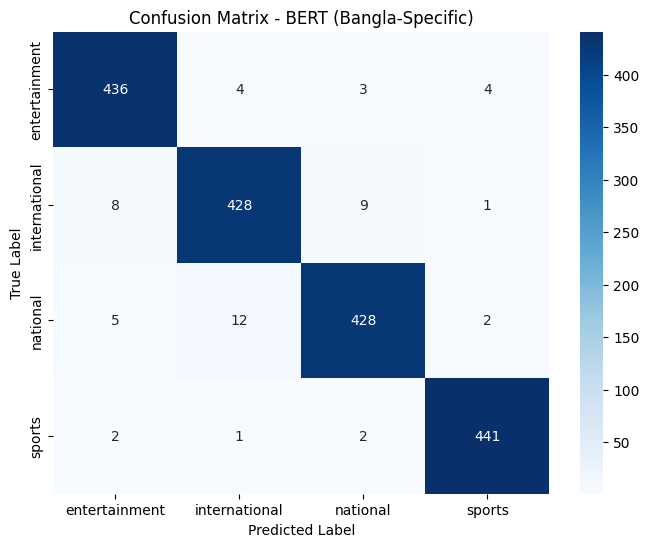

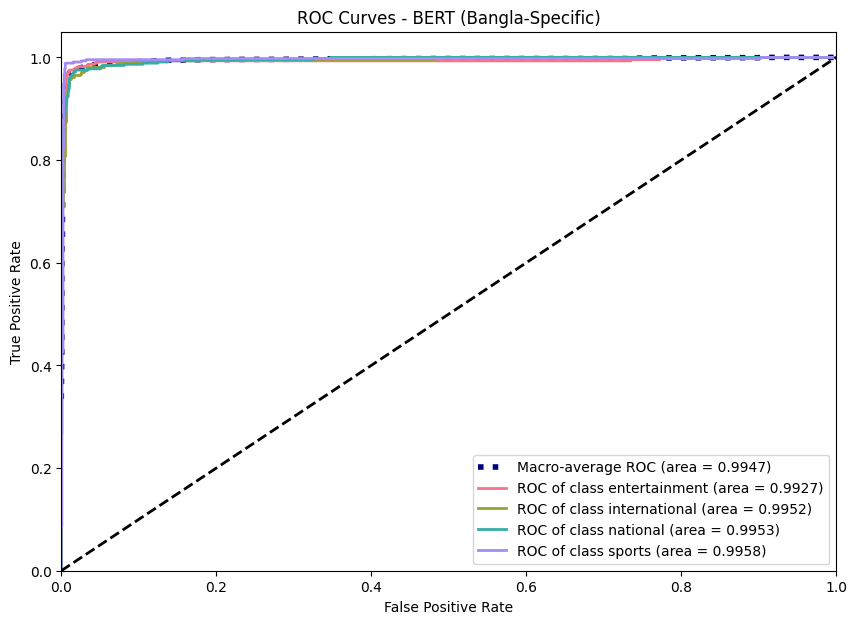

Macro Average AUC-ROC: 0.9947


In [31]:
#  BERT (sagorsarker/bangla-bert-base) with TensorFlow/Keras
# We Uses `X_train_raw`, `X_val_raw`, `X_test_raw`.

BERT_MODEL_BANGLA = "sagorsarker/bangla-bert-base" # Bangla specific

tokenizer_bangla_bert = AutoTokenizer.from_pretrained(BERT_MODEL_BANGLA)

X_train_enc_bangla = tokenizer_bangla_bert(list(X_train_raw), truncation=True, padding='max_length', max_length=MAX_LEN_BERT, return_tensors='tf')
X_val_enc_bangla = tokenizer_bangla_bert(list(X_val_raw), truncation=True, padding='max_length', max_length=MAX_LEN_BERT, return_tensors='tf')
X_test_enc_bangla = tokenizer_bangla_bert(list(X_test_raw), truncation=True, padding='max_length', max_length=MAX_LEN_BERT, return_tensors='tf')

train_bert_bangla_inputs = {'input_ids': X_train_enc_bangla['input_ids'], 'attention_mask': X_train_enc_bangla['attention_mask']}
val_bert_bangla_inputs = {'input_ids': X_val_enc_bangla['input_ids'], 'attention_mask': X_val_enc_bangla['attention_mask']}
test_bert_bangla_inputs = {'input_ids': X_test_enc_bangla['input_ids'], 'attention_mask': X_test_enc_bangla['attention_mask']}


bert_model_bangla = TFAutoModelForSequenceClassification.from_pretrained(BERT_MODEL_BANGLA, num_labels=num_classes)

num_train_steps_bangla = int(len(X_train_raw) / BATCH_SIZE_BERT * EPOCHS_BERT)
num_warmup_steps_bangla = int(0.1 * num_train_steps_bangla)

optimizer_bert_bangla, _ = create_optimizer(
    init_lr=LEARNING_RATE_BERT, 
    num_warmup_steps=num_warmup_steps_bangla,
    num_train_steps=num_train_steps_bangla
)
bert_model_bangla.compile(optimizer=optimizer_bert_bangla, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
bert_model_bangla.summary()

bert_model_bangla.fit(
    train_bert_bangla_inputs, y_train_np,
    validation_data=(val_bert_bangla_inputs, y_val_np),
    epochs=EPOCHS_BERT, batch_size=BATCH_SIZE_BERT
)


y_logits_bert_bangla = bert_model_bangla.predict(test_bert_bangla_inputs)[0]
y_proba_bert_bangla = tf.nn.softmax(y_logits_bert_bangla, axis=1).numpy()
y_pred_bert_bangla = np.argmax(y_proba_bert_bangla, axis=1)
evaluate_model_performance("BERT (Bangla-Specific)", y_test_np, y_pred_bert_bangla, y_proba_bert_bangla)


## 5. Model's Prediction


In [32]:
#  Sample Predictions from All Models on Test Set

# Select 3 random indices from the test set
if len(X_test_raw) >= 3:
    sample_indices = np.random.choice(X_test_raw.index, 3, replace=False) # If X_test_raw is a Series
else:
    print("Not enough samples in the test set for 3 predictions.")
    sample_indices = []


for i, original_idx in enumerate(sample_indices):
    # raw_text_sample = X_test_raw[original_idx] # If X_test_raw is a list
    raw_text_sample = X_test_raw.loc[original_idx] # If X_test_raw is a Pandas Series
    
    # For non-BERT models that used cleaned text:
    cleaned_text_sample_for_rnn_cnn = clean_text_non_bert(raw_text_sample) # Use the function from RNN/CNN
    
    true_label_idx = y_test_np[X_test_raw.index.get_loc(original_idx)] # Get matching label index
    
    true_label_name = label_mapping[true_label_idx]

    print(f"\n--- SAMPLE {i+1} (Original Test Index: {original_idx}) ---")
    print(f"RAW TEXT: {raw_text_sample[:300]}...") # Display first 300 chars
    print(f"TRUE CATEGORY: {true_label_name}")
    print("-" * 30)
    print("MODEL PREDICTIONS:")

    # 1. Logistic Regression (TF-IDF)
    try:
        # Use the TfidfVectorizer fitted for Logistic Regression (tfidf_lr)
        # And the text preprocessed for baseline models
        lr_input = tfidf_lr.transform([cleaned_text_sample_for_rnn_cnn]) # Using rnn/cnn cleaned text for consistency
        lr_pred_idx = lr_model.predict(lr_input)[0]
        print(f"  Logistic Regression: {label_mapping[lr_pred_idx]}")
    except Exception as e:
        print(f"  Logistic Regression: Error - {e}")

    # 2. Random Forest (TF-IDF)
    try:
        # Use the TfidfVectorizer fitted for Random Forest (tfidf_rf)
        rf_input = tfidf_rf.transform([cleaned_text_sample_for_rnn_cnn]) # Using rnn/cnn cleaned text
        rf_pred_idx = rf_model.predict(rf_input)[0]
        print(f"  Random Forest:       {label_mapping[rf_pred_idx]}")
    except Exception as e:
        print(f"  Random Forest:       Error - {e}")

    # 3. LSTM (Keras)
    try:
        # Use the Keras Tokenizer fitted for LSTM/CNN (keras_tokenizer)
        lstm_input_seq = keras_tokenizer.texts_to_sequences([cleaned_text_sample_for_rnn_cnn])
        lstm_input_pad = pad_sequences(lstm_input_seq, maxlen=MAX_LEN_RNN) # MAX_LEN_RNN from LSTM/CNN setup
        lstm_pred_proba = lstm_model.predict(lstm_input_pad, verbose=0)[0]
        lstm_pred_idx = np.argmax(lstm_pred_proba)
        print(f"  LSTM:                {label_mapping[lstm_pred_idx]}")
    except Exception as e:
        print(f"  LSTM:                Error - {e}")

    # 4. CNN (Keras)
    try:
        # Uses same tokenization as LSTM
        cnn_input_seq = keras_tokenizer.texts_to_sequences([cleaned_text_sample_for_rnn_cnn])
        cnn_input_pad = pad_sequences(cnn_input_seq, maxlen=MAX_LEN_RNN)
        cnn_pred_proba = cnn_model.predict(cnn_input_pad, verbose=0)[0]
        cnn_pred_idx = np.argmax(cnn_pred_proba)
        print(f"  CNN:                 {label_mapping[cnn_pred_idx]}")
    except Exception as e:
        print(f"  CNN:                 Error - {e}")

    # 5. BERT (Multilingual)
    try:
        # BERT uses raw_text_sample directly
        bert_multi_enc = tokenizer_multi_bert(raw_text_sample, truncation=True, padding='max_length', max_length=MAX_LEN_BERT, return_tensors='tf') # MAX_LEN_BERT from BERT setup
        bert_multi_inputs_sample = {'input_ids': bert_multi_enc['input_ids'], 'attention_mask': bert_multi_enc['attention_mask']}
        bert_multi_logits = bert_model_multi.predict(bert_multi_inputs_sample, verbose=0)[0]
        bert_multi_proba = tf.nn.softmax(bert_multi_logits, axis=1).numpy()[0]
        bert_multi_pred_idx = np.argmax(bert_multi_proba)
        print(f"  BERT (Multilingual): {label_mapping[bert_multi_pred_idx]}")
    except Exception as e:
        print(f"  BERT (Multilingual): Error - {e}")

    # 6. BERT (Bangla-Specific - sagorsarker/bangla-bert-base)
    try:
        bert_bangla_enc = tokenizer_bangla_bert(raw_text_sample, truncation=True, padding='max_length', max_length=MAX_LEN_BERT, return_tensors='tf')
        bert_bangla_inputs_sample = {'input_ids': bert_bangla_enc['input_ids'], 'attention_mask': bert_bangla_enc['attention_mask']}
        bert_bangla_logits = bert_model_bangla.predict(bert_bangla_inputs_sample, verbose=0)[0]
        bert_bangla_proba = tf.nn.softmax(bert_bangla_logits, axis=1).numpy()[0]
        bert_bangla_pred_idx = np.argmax(bert_bangla_proba)
        print(f"  BERT (Bangla-Spec):  {label_mapping[bert_bangla_pred_idx]}")
    except Exception as e:
        print(f"  BERT (Bangla-Spec):  Error - {e}")

    print("="*60)



--- SAMPLE 1 (Original Test Index: 9883) ---
RAW TEXT: বাজেটে আইএমএফের প্রেসক্রিপশন ফলো করা হয়নি: কাদের [SEP] ফাইল ছবি ২০২৪-২৫ অর্থবছরের জন্য প্রস্তাবিত বাজেটকে বাস্তবসম্মত ও গণমুখী বললেন আওয়ামী লীগ সাধারণ সম্পাদক ওবায়দুল কাদের। তিনি জানালেন, বাজেটে আন্তর্জাতিক মুদ্রা তহবিলের (আইএমএফ) প্রেসক্রিপশন ফলো করা হয়নি। জাতীয় সংসদে ২০২৪-২০২৫ অর্থবছরের বাজেট উপস...
TRUE CATEGORY: national
------------------------------
MODEL PREDICTIONS:
  Logistic Regression: national
  Random Forest:       national
  LSTM:                national
  CNN:                 national
  BERT (Multilingual): national
  BERT (Bangla-Spec):  national

--- SAMPLE 2 (Original Test Index: 9607) ---
RAW TEXT: ছাগলকাণ্ড: রাজস্ব কর্মকর্তা মতিউরের সম্পদ অনুসন্ধানে দুদকের কমিটি [SEP] ফাইল ছবি ছাগলকাণ্ডে আলোচিত জাতীয় রাজস্ব বোর্ডের সদস্য মতিউর রহমানের সম্পদ অনুসন্ধানে তিন সদস্যবিশিষ্ট তদন্ত কমিটি গঠন করেছে দুর্নীতি দমন কমিশন (দুদক)। কমিটির বিষয়টি রোববার (২৩ জুন) নিশ্চিত করেছে দুদক। মতিউরের সাথে দুর্নীতিতে জড...
TRUE CATEGORY:

# 5. Feature Interpretability (LIME) - XAI
## Here we use LIME - Explainable Artificial Intelligence for Model's feature interpretation

Selected BERT (Bangla-Specific) for LIME (Accuracy: 0.9703)

Generating 2 LIME explanations for BERT (Bangla-Specific) on TEST SET samples...

--- Explaining TEST instance 1 (Original Index in X_test: 3210) ---
Text: গাজায় ইসরায়েলি আগ্রাসনের প্রতিবাদে অস্ট্রেলিয়ার পার্লামেন্ট ভবনের ছাদে উঠে বিক্ষোভ [SEP] ছবি: আল জাজিরা থেকে নেয়া গাজায় ইসরায়েলি আগ্রাসনের প্রতিবাদে অস্ট্রেলিয়ার পার্লামেন্ট ভবনের ছাদে উঠে বিক্ষোভের ঘ...
True Label: international
Model Predicted Label: international with probability 0.9989

LIME Explanation for class 'international':
  Word: 'আল', Weight: 0.1134
  Word: 'আল', Weight: 0.0942
  Word: 'খবর', Weight: 0.0820
  Word: 'য়', Weight: 0.0801
  Word: 'র', Weight: 0.0794
  Word: 'জ', Weight: 0.0786
  Word: 'জ', Weight: 0.0756
  Word: 'ল', Weight: 0.0734
  Word: 'জ', Weight: 0.0718
  Word: 'গ', Weight: 0.0680


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2455 (\N{BENGALI LETTER GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2460 (\N{BENGALI LETTER JA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2482 (\N{BENGALI LETTER LA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtoo

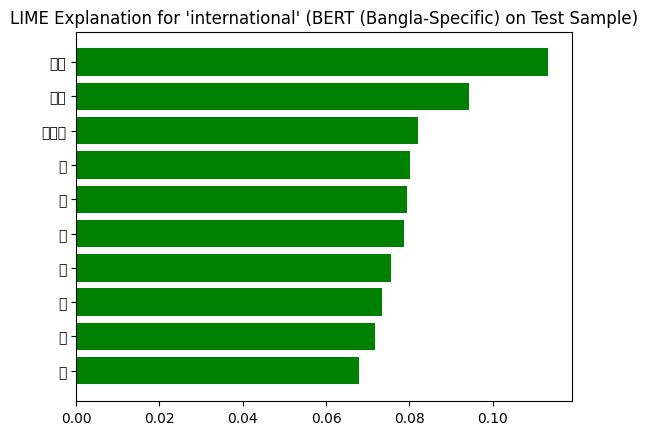


--- Explaining TEST instance 2 (Original Index in X_test: 4332) ---
Text: পশ্চিম তীরে ইসরায়েলি সেনার গুলিতে প্রাণ গেলো এক ফিলিস্তিনির [SEP]  পশ্চিম তীরে ইসরায়েলি সেনার গুলিতে প্রাণ গেছে এক ফিলিস্তিনির। রোববার (১৭ মার্চ) হেবরনে হয় এ ঘটনা। এক প্রতিবেদনে আল আরাবিয়া এ তথ্য জান...
True Label: international
Model Predicted Label: international with probability 0.9988

LIME Explanation for class 'international':
  Word: 'বসত', Weight: 0.0658
  Word: 'আল', Weight: 0.0473
  Word: 'ঘটন', Weight: 0.0404
  Word: 'র', Weight: 0.0402
  Word: 'ত', Weight: 0.0388
  Word: 'ইমস', Weight: 0.0362
  Word: 'ট', Weight: 0.0340
  Word: 'ত', Weight: 0.0332
  Word: 'গ', Weight: -0.0035
  Word: 'গ', Weight: -0.0015


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2455 (\N{BENGALI LETTER GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2468 (\N{BENGALI LETTER TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2463 (\N{BENGALI LETTER TTA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2439 (\N{BENGALI LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtoo

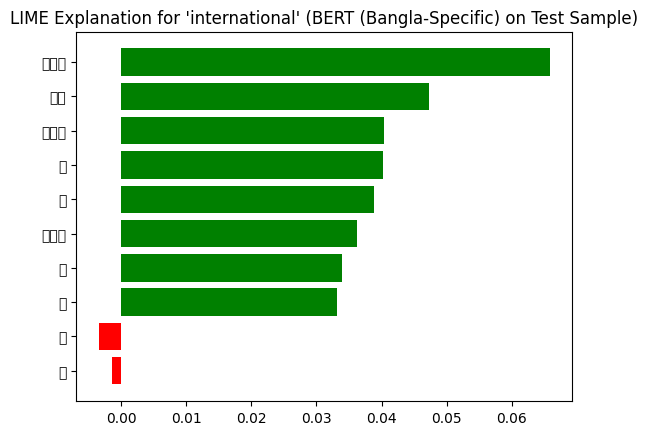

In [33]:
# Feature Interpretability (LIME)

# Applied ths BERT models based on Test Set Accuracy.

bert_bangla_accuracy = model_performance.get('BERT (Bangla-Specific)', {}).get('Accuracy', 0)
bert_multi_accuracy = model_performance.get('BERT (Multilingual)', {}).get('Accuracy', 0)

if bert_bangla_accuracy >= bert_multi_accuracy and 'BERT (Bangla-Specific)' in model_performance:
    best_bert_model_for_lime = bert_model_bangla
    best_tokenizer_for_lime = tokenizer_bangla_bert
    best_bert_model_name = "BERT (Bangla-Specific)"
    X_test_for_lime = X_test_raw 
    print(f"Selected {best_bert_model_name} for LIME (Accuracy: {bert_bangla_accuracy:.4f})")
elif 'BERT (Multilingual)' in model_performance:
    best_bert_model_for_lime = bert_model_multi
    best_tokenizer_for_lime = tokenizer_multi_bert
    best_bert_model_name = "BERT (Multilingual)"
    X_test_for_lime = X_test_raw
    print(f"Selected {best_bert_model_name} for LIME (Accuracy: {bert_multi_accuracy:.4f})")
else:
    best_bert_model_for_lime = None
    print("No BERT models found in performance metrics for LIME. Skipping LIME.")

if best_bert_model_for_lime:
    def predictor_lime_best_bert(texts):
        if isinstance(texts, pd.Series):
            texts = texts.tolist()
        elif not isinstance(texts, list):
            texts = [str(texts)]
            
        encodings = best_tokenizer_for_lime(texts, truncation=True, padding='max_length', max_length=MAX_LEN_BERT, return_tensors="tf")
        tf_inputs = {'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask']}
        logits = best_bert_model_for_lime.predict(tf_inputs, verbose=0)[0] 
        probs = tf.nn.softmax(logits, axis=1).numpy()
        return probs

    explainer_lime = lime.lime_text.LimeTextExplainer(class_names=class_names, bow=False)

    num_lime_explanations = 2 
    print(f"\nGenerating {num_lime_explanations} LIME explanations for {best_bert_model_name} on TEST SET samples...")

    X_test_for_lime_list = list(X_test_for_lime) 

    for i in range(num_lime_explanations):
        if not X_test_for_lime_list:
            print("Test set for LIME is empty.")
            break
        idx_to_explain = np.random.randint(0, len(X_test_for_lime_list))
        text_to_explain = X_test_for_lime_list[idx_to_explain]
        true_label_idx_lime = y_test_np[idx_to_explain] 
        
        print(f"\n--- Explaining TEST instance {i+1} (Original Index in X_test: {X_test_for_lime.index[idx_to_explain] if isinstance(X_test_for_lime, pd.Series) else idx_to_explain}) ---")
        print(f"Text: {text_to_explain[:200]}...")
        print(f"True Label: {label_mapping[true_label_idx_lime]}")

        model_probs = predictor_lime_best_bert([text_to_explain])[0]
        predicted_class_idx = np.argmax(model_probs)
        print(f"Model Predicted Label: {label_mapping[predicted_class_idx]} with probability {model_probs[predicted_class_idx]:.4f}")
        
        try:
            explanation = explainer_lime.explain_instance(
                text_to_explain,
                predictor_lime_best_bert,
                num_features=10,
                top_labels=1 
            )
            print(f"\nLIME Explanation for class '{label_mapping[explanation.top_labels[0]]}':")
            for feature, weight in explanation.as_list(label=explanation.top_labels[0]):
                print(f"  Word: '{feature}', Weight: {weight:.4f}")
            
            fig = explanation.as_pyplot_figure(label=explanation.top_labels[0])
            plt.title(f"LIME Explanation for '{label_mapping[explanation.top_labels[0]]}' ({best_bert_model_name} on Test Sample)")
            if BANGLA_FONT_PATH:
                 for text_obj in fig.get_default_bbox_extra_artists():
                     if isinstance(text_obj, plt.Text):
                         try:
                             text_obj.set_fontname(os.path.basename(BANGLA_FONT_PATH).split('.')[0]) 
                         except:
                             try:
                                 from matplotlib.font_manager import FontProperties
                                 font_prop = FontProperties(fname=BANGLA_FONT_PATH)
                                 text_obj.set_fontproperties(font_prop)
                             except: pass 
            plt.show()
        except Exception as e:
            print(f"Could not generate LIME explanation for instance {idx_to_explain}: {e}")


# 6. Result Comparison between our 6 models


 Model Performance Comparison on TEST SET
                        Accuracy  Macro F1  Weighted F1  Macro AUC
BERT (Bangla-Specific)  0.970325  0.970305     0.970302   0.994724
BERT (Multilingual)     0.957447  0.957439     0.957434   0.993392
CNN                     0.956327  0.956308     0.956303   0.995778
LSTM                    0.944569  0.944724     0.944717   0.991060
Logistic Regression     0.917693  0.917700     0.917695   0.988579
Random Forest           0.903695  0.903463     0.903457   0.980202


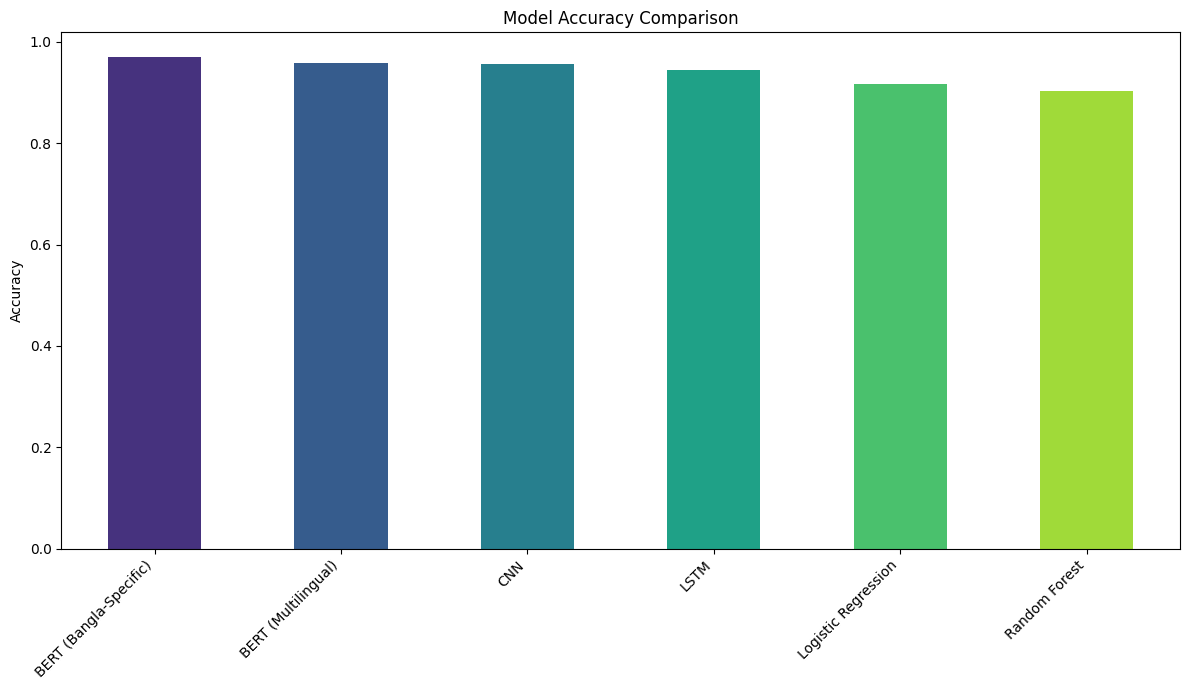

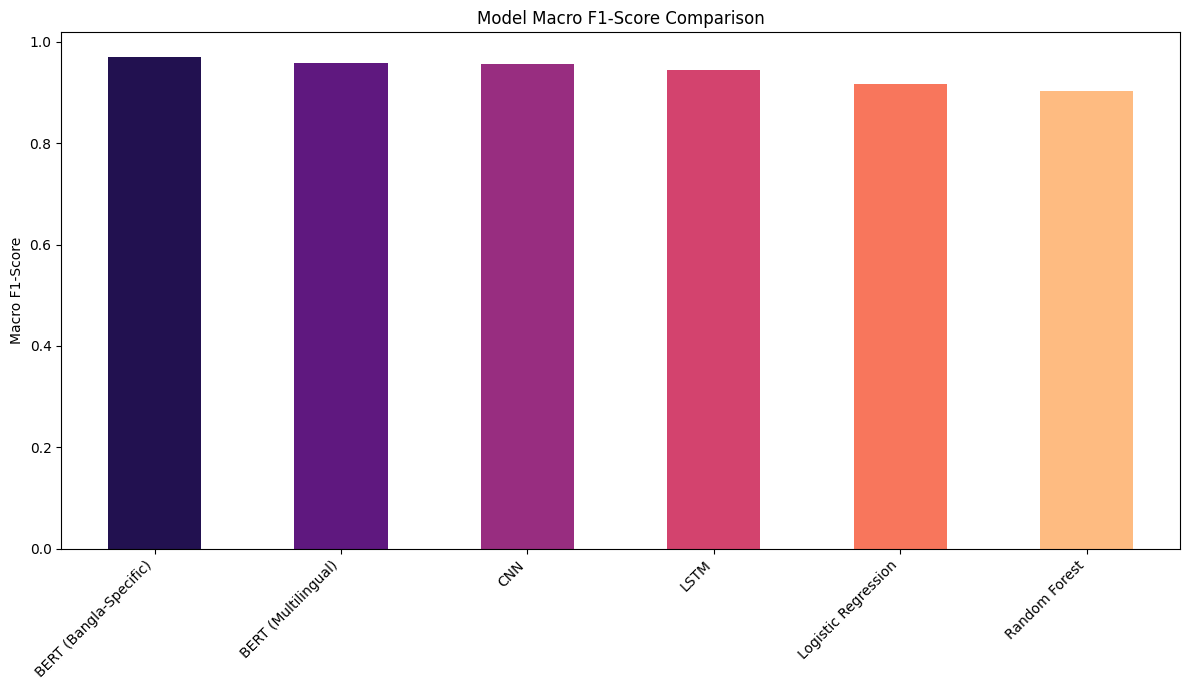

In [34]:
# Result Comparison 

performance_df = pd.DataFrame.from_dict(model_performance, orient='index')
performance_df = performance_df.sort_values(by='Accuracy', ascending=False)

print("\n Model Performance Comparison on TEST SET")
print(performance_df)

plt.figure(figsize=(12, 7))
performance_df['Accuracy'].plot(kind='bar', color=sns.color_palette("viridis", len(performance_df)))
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 7))
performance_df['Macro F1'].plot(kind='bar', color=sns.color_palette("magma", len(performance_df)))
plt.title('Model Macro F1-Score Comparison')
plt.ylabel('Macro F1-Score')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# 7. Important Findings - Overall Performance


 Detailed Model Performance Comparison on TEST SET

 Model Performance Summary Table on TEST SET 
                 Model Accuracy Macro Precision Macro Recall Macro F1-Score Weighted F1-Score Macro AUC
BERT (Bangla-Specific)   0.9703             N/A          N/A         0.9703            0.9703    0.9947
   BERT (Multilingual)   0.9574             N/A          N/A         0.9574            0.9574    0.9934
                   CNN   0.9563             N/A          N/A         0.9563            0.9563    0.9958
                  LSTM   0.9446             N/A          N/A         0.9447            0.9447    0.9911
   Logistic Regression   0.9177             N/A          N/A         0.9177            0.9177    0.9886
         Random Forest   0.9037             N/A          N/A         0.9035            0.9035    0.9802


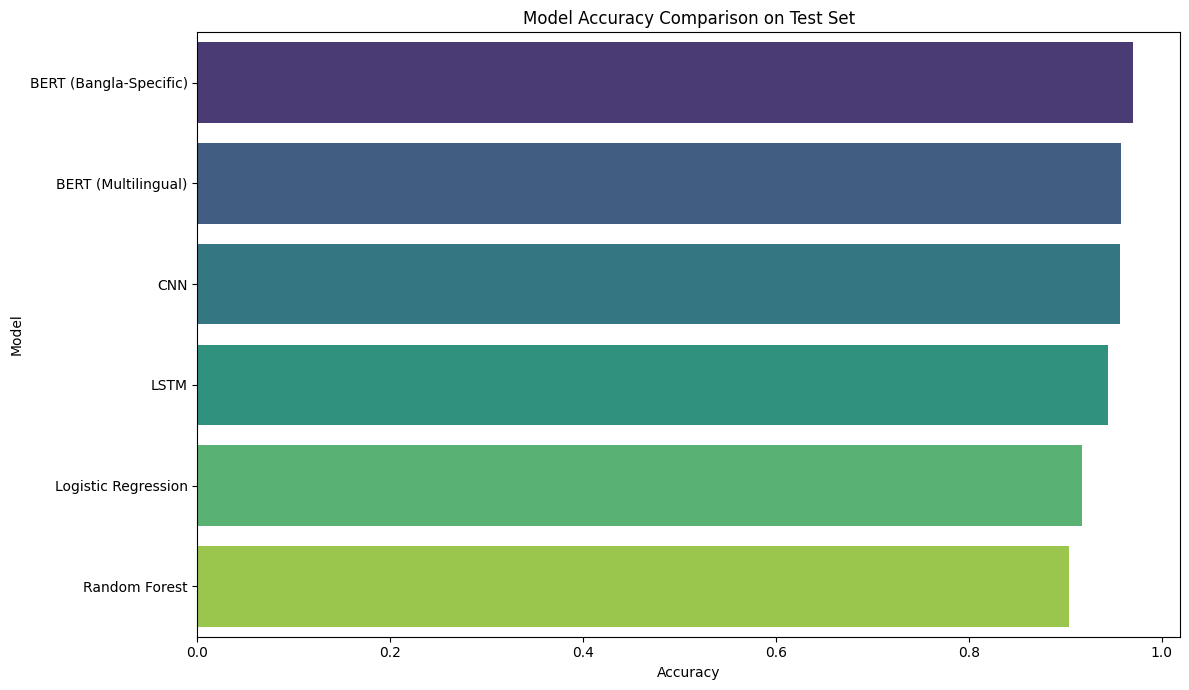

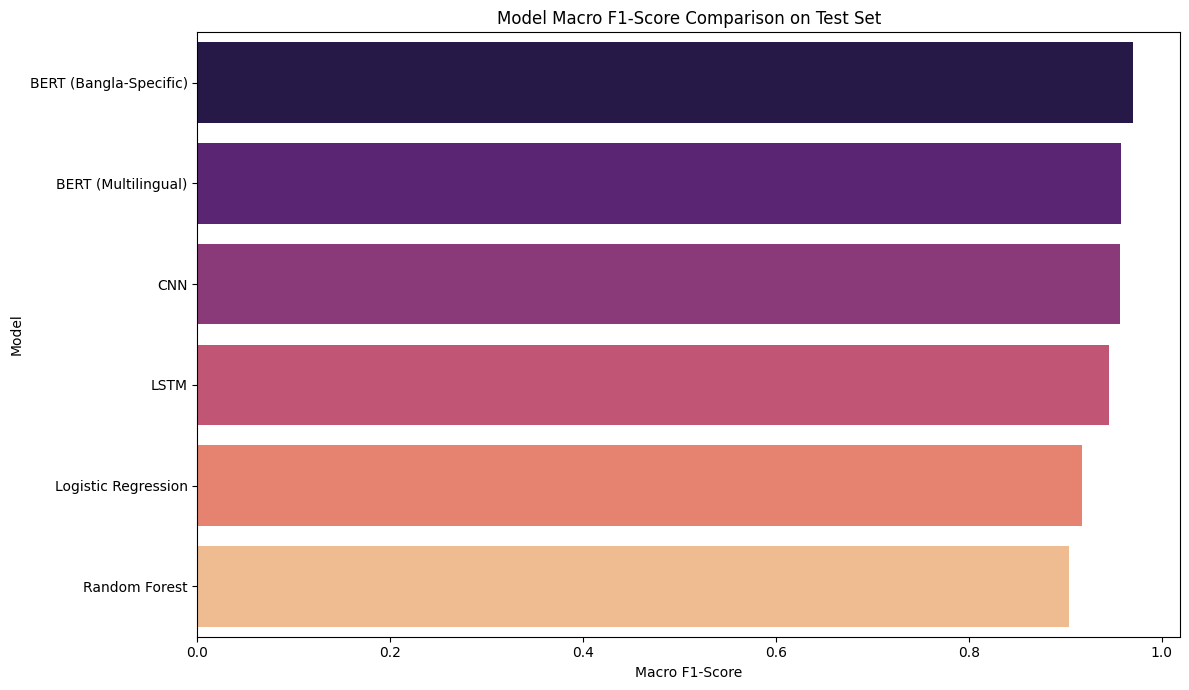

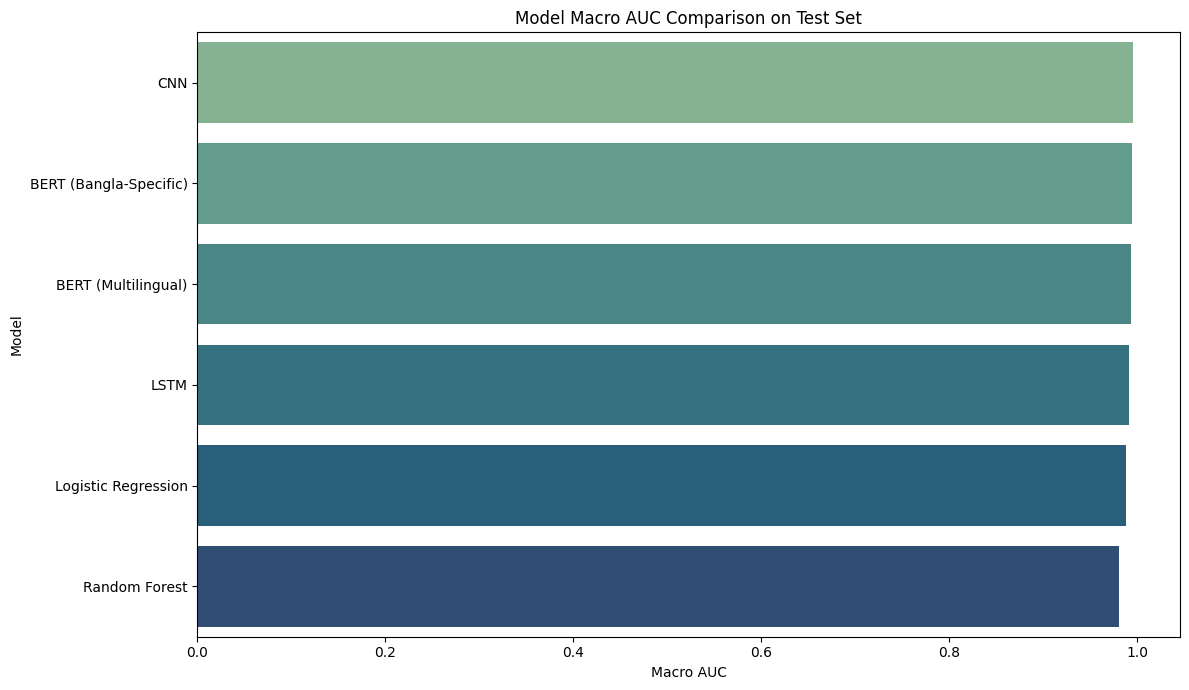

In [35]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


print("\n Detailed Model Performance Comparison on TEST SET")

table_data = []
for model_name, metrics in model_performance.items():
    # Overall metrics
    table_data.append({
        'Model': model_name,
        'Class': 'Accuracy',
        'Precision': '',
        'Recall': '',
        'F1-Score': metrics['Accuracy'], 
        'Support': '' 
    })
    table_data.append({
        'Model': model_name,
        'Class': 'Macro Avg F1',
        'Precision': '', 
        'Recall': '',
        'F1-Score': metrics['Macro F1'],
        'Support': ''
    })
    table_data.append({
        'Model': model_name,
        'Class': 'Weighted Avg F1',
        'Precision': '',
        'Recall': '',
        'F1-Score': metrics['Weighted F1'],
        'Support': ''
    })
    table_data.append({
        'Model': model_name,
        'Class': 'Macro AUC',
        'Precision': '',
        'Recall': '',
        'F1-Score': metrics['Macro AUC'],
        'Support': ''
    })

    report_dict = metrics.get('report_dict') 
    if report_dict:
        for class_label in class_names: 
            if class_label in report_dict:
                table_data.append({
                    'Model': model_name,
                    'Class': class_label,
                    'Precision': report_dict[class_label]['precision'],
                    'Recall': report_dict[class_label]['recall'],
                    'F1-Score': report_dict[class_label]['f1-score'],
                    'Support': report_dict[class_label]['support']
                })
        if 'macro avg' in report_dict:
             table_data.append({
                'Model': model_name,
                'Class': 'Macro Avg (from report)',
                'Precision': report_dict['macro avg']['precision'],
                'Recall': report_dict['macro avg']['recall'],
                'F1-Score': report_dict['macro avg']['f1-score'],
                'Support': report_dict['macro avg']['support']
            })
        if 'weighted avg' in report_dict:
             table_data.append({
                'Model': model_name,
                'Class': 'Weighted Avg (from report)',
                'Precision': report_dict['weighted avg']['precision'],
                'Recall': report_dict['weighted avg']['recall'],
                'F1-Score': report_dict['weighted avg']['f1-score'],
                'Support': report_dict['weighted avg']['support']
            })


performance_details_df = pd.DataFrame(table_data)


summary_table_data = []
for model_name, metrics in model_performance.items():
    summary_table_data.append({
        'Model': model_name,
        'Accuracy': metrics.get('Accuracy', 'N/A'),
        'Macro Precision': metrics.get('report_dict', {}).get('macro avg', {}).get('precision', 'N/A'),
        'Macro Recall': metrics.get('report_dict', {}).get('macro avg', {}).get('recall', 'N/A'),
        'Macro F1-Score': metrics.get('Macro F1', 'N/A'), 
        'Weighted F1-Score': metrics.get('Weighted F1', 'N/A'), 
        'Macro AUC': metrics.get('Macro AUC', 'N/A')
    })

summary_performance_df = pd.DataFrame(summary_table_data)
summary_performance_df = summary_performance_df.sort_values(by='Accuracy', ascending=False)

print("\n Model Performance Summary Table on TEST SET ")
float_cols = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Weighted F1-Score', 'Macro AUC']
for col in float_cols:
    if col in summary_performance_df.columns:
        summary_performance_df[col] = summary_performance_df[col].apply(lambda x: f"{x:.4f}" if isinstance(x, float) else x)

print(summary_performance_df.to_string(index=False))




# Create a numeric version of the DataFrame for plotting
plot_df = pd.DataFrame.from_dict(model_performance, orient='index').reset_index().rename(columns={'index': 'Model'})
plot_df = plot_df.sort_values(by='Accuracy', ascending=False)


plt.figure(figsize=(12, 7))
sns.barplot(x='Accuracy', y='Model', data=plot_df, palette="viridis", orient='h')
plt.title('Model Accuracy Comparison on Test Set')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 7))
sns.barplot(x='Macro F1', y='Model', data=plot_df, palette="magma", orient='h')
plt.title('Model Macro F1-Score Comparison on Test Set')
plt.xlabel('Macro F1-Score')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 7))
plot_df_auc = plot_df[plot_df['Macro AUC'] != 'N/A'].copy()
plot_df_auc['Macro AUC'] = pd.to_numeric(plot_df_auc['Macro AUC'])
plot_df_auc = plot_df_auc.sort_values(by='Macro AUC', ascending=False)

sns.barplot(x='Macro AUC', y='Model', data=plot_df_auc, palette="crest", orient='h')
plt.title('Model Macro AUC Comparison on Test Set')
plt.xlabel('Macro AUC')
plt.ylabel('Model')
plt.tight_layout()
plt.show()
